## <center>Домашнее задание № 3 
### <center> Деревья решений для классификации и регрессии

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

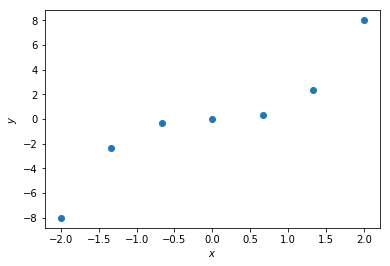

In [3]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)

plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

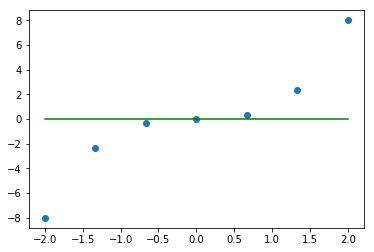

In [4]:
X = np.linspace(-2, 2, 7)
y = X ** 3

x_val  = np.linspace(-2, 2, 100)
predict = [np.mean(y) for x in x_val]

plt.scatter(X, y)
plt.plot(x_val, predict, color='green');

#y_sqrd = (y - (np.sum(y) / len(X))) ** 2
#D_X = (1 / len(X)) * np.sum(y_sqrd)
#print(D_X)
#plt.scatter(X, y_sqrd);

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

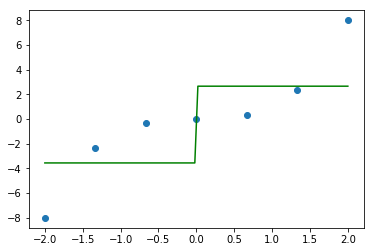

In [5]:
X = np.linspace(-2, 2, 7)
y = X ** 3

x_vals = np.linspace(-2, 2, 100)
predicts = [np.mean(y[X < 0]) if x < 0 else np.mean(y[X >= 0]) for x in x_vals]

plt.scatter(X, y)
plt.plot(x_val, predicts, color='green');

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [6]:
def regression_var_criterion(X, y, t):
    X_l = X[X < t]
    X_r = X[X >= t]
    y_l = y[X < t]
    y_r = y[X >= t]

    return np.var(y) - X_l.shape[0] / X.shape[0] * np.var(y_l) - X_r.shape[0] / X.shape[0] * np.var(y_r)

# if len(X[X<t] == 0) or len(X[X>=t] == 0):
#     return 0
# else:
#     # x<t
#     y_neg = (y[y<t] - (np.sum(y[y<t]) / len(X[X<t]))) ** 2
#     D_X_l = (1 / len(X[X<t])) * np.sum(y_neg)
#     # x>=t
#     y_pos = (y[y>=t] - (np.sum(y[y>=t]) / len(X[X>=t]))) ** 2
#     D_X_r = (1 / len(X[X>=t])) * np.sum(y_pos)
#     return D_X - (len(X[X<t]) / len(X)) * D_X_l - (len(X[X>=t]) / len(X)) * D_X_r

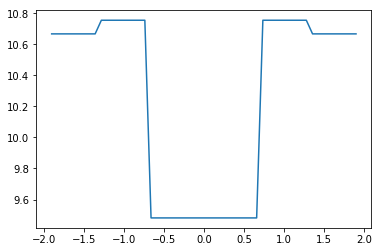

In [7]:
tr = np.linspace(-1.9, 1.9, 50)
q = [regression_var_criterion(X, y, t) for t in tr]
plt.plot(tr, q);

In [8]:
# Вопрос 1: Нет.

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- **Нет**

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

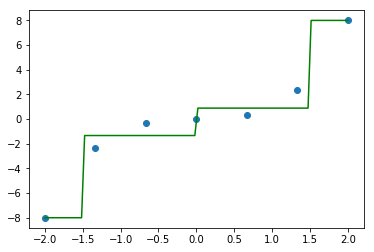

In [9]:
X = np.linspace(-2, 2, 7)
y = X ** 3

x_values = np.linspace(-2, 2, 100)

def prediction(x, X, y):
    if x >= 1.5:
        return np.mean(y[X >= 1.5])
    elif x >= 0 and x < 1.5:
        return np.mean(y[(X >= 0) & (X < 1.5)])
    elif x < 0 and x >= -1.5:
        return np.mean(y[(X < 0) & (X >= -1.5)])
    else:
        return np.mean(y[X < -1.5])
    
predictions = [prediction(x, X, y) for x in x_values]

plt.scatter(X, y);
plt.plot(x_values, predictions, c='green');

In [10]:
# Вопрос 2: 7.

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- **7**
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [11]:
df = pd.read_csv('data/mlbootcamp5_train.csv', index_col='id', sep=';')
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [12]:
df['age_years'] = (df['age'] / 365).round()
df.drop('age', axis=1, inplace=True)

df = pd.get_dummies(df, columns=['gluc', 'cholesterol'])

df.head(3)

,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_years,gluc_1,gluc_2,gluc_3,cholesterol_1,cholesterol_2,cholesterol_3
id,,,,,,,,,,,,,,,,
0,2,168,62.0,110,80,0,0,1,0,50.0,1,0,0,1,0,0
1,1,156,85.0,140,90,0,0,1,1,55.0,1,0,0,0,0,1
2,1,165,64.0,130,70,0,0,0,1,52.0,1,0,0,0,0,1


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [13]:
df_c = df.drop(['cardio'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(df_c, df['cardio'], train_size=0.7, test_size=0.3, random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [14]:
tr = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)
tr.fit(X_train, y_train)

#export_graphviz(tr, out_file='tree.dot', filled=True)
#!dot -Tpng tree.dot -o tree.png
#!rm tree.dot

#X_train[(X_train['ap_hi'] <= 129.5) & (X_train['age_years'] >= 54.5) & (X_train['cholesterol_3'] >= 0.5)].shape

# Вопрос 3: age, ap_hi, chol=3

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [15]:
X_valid.head()
tr_pred = tr.predict(X_valid)
accuracy_score(y_valid, tr_pred)

0.7212857142857143

In [16]:
# Метод ближайших соседей
#from sklearn.neighbors import KNeighborsClassifier

#knn = KNeighborsClassifier(n_neighbors=10)
#knn.fit(X_train, y_train)

#knn_pred = knn.predict(X_valid)
#accuracy_score(y_valid, knn_pred)

# Итог: 0.7068571428571429

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [17]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(tr, tree_params, cv=5, verbose=True)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    6.9s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [18]:
tree_grid.best_params_

{'max_depth': 6}

In [19]:
tree_grid.best_score_

0.7317142857142858

In [20]:
accuracy_score(y_valid, tree_grid.predict(X_valid))

0.7262380952380952

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

In [21]:
#vals = []
#depths = [j for j in range(2, 11)]

#for i in range(2, 11):
#    t_params = {'max_depth': list(range(i, i + 1))}
#    tr_grid = GridSearchCV(tr, t_params, cv=5, verbose=True)
#    tr_grid.fit(X_train, y_train)
#    vals.append(tr_grid.best_score_)

In [22]:
#vals

In [23]:
#depths

In [24]:
tree_grid.cv_results_['mean_test_score']

array([0.7155102 , 0.72771429, 0.72981633, 0.73140816, 0.73171429,
       0.73104082, 0.73034694, 0.72991837, 0.72685714])

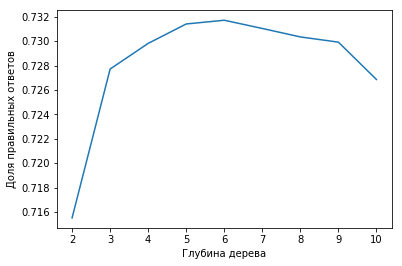

In [25]:
plt.plot(list(range(2, 11)), tree_grid.cv_results_['mean_test_score'])
plt.xlabel('Глубина дерева')  # max_depth
plt.ylabel('Доля правильных ответов');  # accuracy

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [26]:
t_params = {'max_depth': list(range(6, 7))}
tr_grid = GridSearchCV(tr, t_params, cv=5, verbose=True)
tr_grid.fit(X_train, y_train)

tr_grid.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


0.7317142857142858

In [27]:
accuracy_score(y_valid, tr_grid.predict(X_valid))

0.7262380952380952

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- **да, нет**
- нет, да
- нет, нет

In [28]:
acc1 = 0.7212857142857143
acc2 = 0.7262380952380952

(acc2 - acc1) / acc1 * 100
# 0.6866046081732325 - это менее 1 процента.

# Вопрос 4: да, нет

0.6866046081732325

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='https://habrastorage.org/webt/gg/38/vf/gg38vfl5ql8obqjmlsvt9es76p8.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [29]:
df.head(3)

,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_years,gluc_1,gluc_2,gluc_3,cholesterol_1,cholesterol_2,cholesterol_3
id,,,,,,,,,,,,,,,,
0,2,168,62.0,110,80,0,0,1,0,50.0,1,0,0,1,0,0
1,1,156,85.0,140,90,0,0,1,1,55.0,1,0,0,0,0,1
2,1,165,64.0,130,70,0,0,0,1,52.0,1,0,0,0,0,1


In [30]:
#feat = ['height', 'weight', 'ap_lo', 'alco', 'active', 'gluc_1', 'gluc_2', 'gluc_3', 'cardio']
#df.drop(feat, axis=1, inplace=True)

In [31]:
# age manipulations

df['age_45_49'] = df['age_years'].map(lambda x: 1 if x >= 45 and x < 50 else 0)
df['age_50_54'] = df['age_years'].map(lambda x: 1 if x >= 50 and x < 55 else 0)
df['age_55_59'] = df['age_years'].map(lambda x: 1 if x >= 55 and x < 60 else 0)
df['age_60_64'] = df['age_years'].map(lambda x: 1 if x >= 60 and x < 65 else 0)

In [32]:
# age_hi manipulations

df['ap_hi_120_139'] = df['ap_hi'].map(lambda x: 1 if x >= 120 and x < 140 else 0)
df['ap_hi_140_159'] = df['ap_hi'].map(lambda x: 1 if x >= 140 and x < 160 else 0)
df['ap_hi_160_179'] = df['ap_hi'].map(lambda x: 1 if x >= 160 and x < 180 else 0)

In [33]:
df.drop(['age_years', 'ap_hi'], axis=1, inplace=True)

In [34]:
#dumm cholesterol
#done

In [35]:
# gender into male

df['male'] = df['gender'].map(lambda x: 1 if x == 2 else 0)
df.drop('gender', axis=1, inplace=True)

In [36]:
df.head()

,height,weight,ap_lo,smoke,alco,active,cardio,gluc_1,gluc_2,gluc_3,...,cholesterol_2,cholesterol_3,age_45_49,age_50_54,age_55_59,age_60_64,ap_hi_120_139,ap_hi_140_159,ap_hi_160_179,male
id,,,,,,,,,,,,,,,,,,,,,
0,168,62.0,80,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,156,85.0,90,0,0,1,1,1,0,0,...,0,1,0,0,1,0,0,1,0,0
2,165,64.0,70,0,0,0,1,1,0,0,...,0,1,0,1,0,0,1,0,0,0
3,169,82.0,100,0,0,1,1,1,0,0,...,0,0,1,0,0,0,0,1,0,1
4,156,56.0,60,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [37]:
d = pd.read_csv('data/mlbootcamp5_train.csv', index_col='id', sep=';')

In [38]:
trr = DecisionTreeClassifier(max_depth=3, random_state=17)
trr.fit(df, d['cardio'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [39]:
#export_graphviz(trr, out_file='tr5.dot', filled=True)
#!dot -Tpng tr5.dot -o tr5.png
#!rm tr5.dot

In [40]:
# Вопрос 5: Верхнее артериальное давление от 140 до 160 (мм рт.ст.)

df[df['ap_hi_140_159'] <= 0.5].shape

(55564, 21)